<a href="https://colab.research.google.com/github/Oxshadha/Bio-Fusion/blob/main/InsightAi_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gastric Cancer Histopathology Tissue Classification using Hybrid Ensemble (EfficientNet + ViT)

## Project Overview

This notebook implements a **hybrid ensemble** deep learning solution for automated classification of gastric cancer histopathology tissue images. The model combines **EfficientNet-B4** (CNN) and **ViT-Base** (Vision Transformer) architectures with **attention-based feature fusion** to leverage the strengths of both CNN and Transformer approaches.

---

## Table of Contents

1. [Problem Definition](#1-problem-definition)
2. [Dataset Documentation](#2-dataset-documentation)
3. [Model Initialization & Pretraining Disclosure](#3-model-initialization--pretraining-disclosure)
4. [Model Development](#4-model-development)
5. [Training Process](#5-training-process)
6. [Outputs & Logs](#6-outputs--logs)
7. [Performance Metrics](#7-performance-metrics)
8. [Reproducibility](#8-reproducibility)
9. [Final Model](#9-final-model)
10. [Conclusion](#10-conclusion)


# 1. Problem Definition

## 1.1 Clinical/Healthcare Relevance

**Gastric cancer** (stomach cancer) is the **fifth most common cancer** and **third leading cause of cancer-related deaths** worldwide. Early and accurate diagnosis is crucial for effective treatment and improved patient outcomes.

### Current Diagnostic Challenges:

1. **Manual Histopathology Analysis**: Pathologists manually examine tissue slides under microscopes, which is:
   - Time-consuming (can take hours per case)
   - Subjective (inter-observer variability)
   - Resource-intensive (requires highly trained specialists)

2. **Tissue Microenvironment Complexity**: Gastric cancer tissue contains multiple components (tumor, stroma, lymphocytes, etc.) that must be accurately identified for:
   - Accurate staging
   - Treatment planning
   - Prognosis assessment

3. **Growing Demand**: With increasing cancer cases, there's a need for:
   - Faster diagnosis
   - Consistent, reproducible results
   - Scalable solutions

## 1.2 What is Being Predicted?

This model classifies histopathology tissue images into **8 distinct tissue types**:

- **ADI**: Adipose (fat tissue)
- **DEB**: Debris (cellular waste)
- **LYM**: Lymphocytes (immune cells)
- **MUC**: Mucus (protective secretion)
- **MUS**: Smooth Muscle (muscle tissue)
- **NOR**: Normal Colon Mucosa (healthy tissue)
- **STR**: Cancer-associated Stroma (connective tissue around tumor)
- **TUM**: Tumor epithelium (cancerous tissue)

### Clinical Significance:

- **Tumor (TUM)** identification is critical for cancer detection
- **Lymphocytes (LYM)** and **Stroma (STR)** indicate immune response and tumor microenvironment
- Accurate classification enables:
  - Automated tissue quantification
  - Tumor-Stroma Ratio (TSR) calculation
  - Tumor-Infiltrating Lymphocyte (TIL) scoring
  - Objective, reproducible tissue analysis

## 1.3 Why Deep Learning?

Deep learning models can:
- **Process large volumes** of histopathology images quickly
- **Learn complex patterns** in tissue morphology
- **Provide consistent** classifications (reducing inter-observer variability)
- **Scale** to handle increasing diagnostic demands
- **Assist pathologists** by providing second opinions and highlighting regions of interest

## 1.4 Why Hybrid Ensemble?


- **CNN (EfficientNet)**: Excellent at capturing local texture patterns and spatial relationships
- **Transformer (ViT)**: Captures long-range dependencies and global context
- **Ensemble Effect**: Complementary features improve overall performance
- **Attention Fusion**: Learns which features to emphasize from each architecture


# 2. Dataset Documentation

## 2.1 Full Citation

**Dataset**: Gastric Cancer Histopathology Tissue Image Dataset (GCHTID)

**Citation**:
```
Shenghan Lou, Jianxin Ji, Xuan Zhang, Huiying Li, Yang Jiang, Menglei Hua,
Kexin Chen, Xiaohan Zheng, Qi Zhang, Peng Han, Lei Cao, & Liuying Wang. (2024).
Gastric Cancer Histopathology Tissue Image Dataset (GCHTID) [Data set].
figshare. https://doi.org/10.6084/m9.figshare.26014469.v
```

**Original Publication**:
- Nature Scientific Data: https://www.nature.com/articles/s41597-025-04489-9

**Dataset Source**:
- Kaggle: https://www.kaggle.com/datasets/orvile/gastric-cancer-histopathology-tissue-image-dataset
- Figshare DOI: https://doi.org/10.6084/m9.figshare.26014469.v

**License**: Creative Commons Attribution 4.0 International (CC BY 4.0)

## 2.2 Variables/Labels Description

The dataset contains **31,096 histopathology tissue images** extracted from **300 whole slide images** obtained from Harbin Medical University Cancer Hospital.

### Image Characteristics:
- **Size**: 224×224 pixels
- **Format**: RGB (3 channels)
- **Source**: H&E-stained pathological slides
- **Extraction**: Non-overlapping tiles from whole slide images

### Class Labels (8 tissue types):

| Class | Code | Description | Clinical Significance |
|-------|------|-------------|----------------------|
| Adipose | ADI | Fat tissue | Normal tissue component |
| Debris | DEB | Cellular waste | Background/non-tissue |
| Lymphocytes | LYM | Immune cells | Immune response indicator |
| Mucus | MUC | Protective secretion | Normal mucosal component |
| Smooth Muscle | MUS | Muscle tissue | Normal tissue component |
| Normal Mucosa | NOR | Healthy tissue | Reference for comparison |
| Stroma | STR | Connective tissue around tumor | Tumor microenvironment |
| Tumor | TUM | Cancerous tissue | **Primary target for detection** |

## 2.3 Data Distribution & Basic Analysis

We will analyze the class distribution to understand dataset balance and potential biases.


In [ ]:
# Install required packages
!pip install -q timm opencv-python kaggle

# # Mount Google Drive (optional, for saving models)
# from google.colab import drive
# drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Setup Kaggle API (upload kaggle.json file)
from google.colab import files
uploaded = files.upload()  # Upload kaggle.json

# Configure Kaggle
import os
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
print("✓ Kaggle API configured")


Saving kaggle.json to kaggle.json
✓ Kaggle API configured


In [26]:
# Install required packages
!pip install -q timm opencv-python kagglehub




In [27]:
# Download dataset using kagglehub
import kagglehub
import os

print("="*60)
print("DOWNLOADING DATASET")
print("="*60)
print("Dataset: Gastric Cancer Histopathology Tissue Image Dataset (GCHTID)")
print("Source: https://www.kaggle.com/datasets/orvile/gastric-cancer-histopathology-tissue-image-dataset")
print()

path = kagglehub.dataset_download("orvile/gastric-cancer-histopathology-tissue-image-dataset")
print(f"\n✓ Dataset downloaded to: {path}")

# Set dataset path dynamically
DATASET_PATH = os.path.join(path, "HMU-GC-HE-30K/all_image")
print(f"✓ Dataset path: {DATASET_PATH}")


DOWNLOADING DATASET
Dataset: Gastric Cancer Histopathology Tissue Image Dataset (GCHTID)
Source: https://www.kaggle.com/datasets/orvile/gastric-cancer-histopathology-tissue-image-dataset



100%|██████████| 3.03G/3.03G [00:38<00:00, 85.3MB/s]

Extracting files...



✓ Dataset downloaded to: /root/.cache/kagglehub/datasets/orvile/gastric-cancer-histopathology-tissue-image-dataset/versions/1
✓ Dataset path: /root/.cache/kagglehub/datasets/orvile/gastric-cancer-histopathology-tissue-image-dataset/versions/1/HMU-GC-HE-30K/all_image


In [ ]:
# # Download and extract dataset
# print("Downloading dataset from Kaggle...")
# print("Dataset: Gastric Cancer Histopathology Tissue Image Dataset (GCHTID)")
# print("Source: https://www.kaggle.com/datasets/orvile/gastric-cancer-histopathology-tissue-image-dataset")
# print()

# !kaggle datasets download -d orvile/gastric-cancer-histopathology-tissue-image-dataset

# print("\nExtracting dataset...")
# !unzip -q gastric-cancer-histopathology-tissue-image-dataset.zip -d GCHTID

# print("✓ Dataset downloaded and extracted to /content/GCHTID")
# print(f"Dataset path: /content/GCHTID/HMU-GC-HE-30K/all_image")


Dataset: Gastric Cancer Histopathology Tissue Image Dataset (GCHTID)
Source: https://www.kaggle.com/datasets/orvile/gastric-cancer-histopathology-tissue-image-dataset

Dataset URL: https://www.kaggle.com/datasets/orvile/gastric-cancer-histopathology-tissue-image-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
 97% 2.95G/3.03G [00:39<00:01, 44.8MB/s]
100% 3.03G/3.03G [00:40<00:00, 81.3MB/s]

Extracting dataset...
✓ Dataset downloaded and extracted to /content/GCHTID
Dataset path: /content/GCHTID/HMU-GC-HE-30K/all_image


In [ ]:
# ============================================================================
# IMPORT ALL REQUIRED LIBRARIES
# ============================================================================
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, matthews_corrcoef
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import json
import cv2
import timm
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION CONSTANTS
# ============================================================================
DATASET_PATH = "/content/GCHTID/HMU-GC-HE-30K/all_image"
CLASSES = ['ADI', 'DEB', 'LYM', 'MUC', 'MUS', 'NOR', 'STR', 'TUM']
NUM_CLASSES = len(CLASSES)
CLASS_TO_IDX = {cls: idx for idx, cls in enumerate(CLASSES)}
IDX_TO_CLASS = {idx: cls for cls, idx in CLASS_TO_IDX.items()}
RANDOM_SEED = 42
BATCH_SIZE = 32
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# ============================================================================
# REPRODUCIBILITY
# ============================================================================
def set_seeds(seed=RANDOM_SEED):
    """Set all random seeds for reproducibility"""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# ============================================================================
# DEVICE SETUP
# ============================================================================
def get_device():
    """Get the best available device (CUDA > MPS > CPU)"""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"✓ Using CUDA: {torch.cuda.get_device_name(0)}")
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        device = torch.device("mps")
        print("✓ Using MPS (Apple Silicon)")
    else:
        device = torch.device("cpu")
        print("⚠ Using CPU")
    return device

# ============================================================================
# FOCAL LOSS
# ============================================================================
class FocalLoss(nn.Module):
    """Focal Loss with Label Smoothing for addressing hard examples"""
    def __init__(self, alpha=0.25, gamma=2.0, label_smoothing=0.1, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.label_smoothing = label_smoothing
        self.reduction = reduction

    def forward(self, inputs, targets):
        num_classes = inputs.size(1)
        if self.label_smoothing > 0:
            targets_one_hot = torch.zeros_like(inputs)
            targets_one_hot.scatter_(1, targets.unsqueeze(1), 1)
            targets_one_hot = targets_one_hot * (1 - self.label_smoothing) + self.label_smoothing / num_classes
            log_probs = F.log_softmax(inputs, dim=1)
            pt = torch.sum(targets_one_hot * torch.exp(log_probs), dim=1)
            ce_loss = -torch.sum(targets_one_hot * log_probs, dim=1)
        else:
            ce_loss = F.cross_entropy(inputs, targets, reduction='none')
            pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# ============================================================================
# CLAHE TRANSFORM
# ============================================================================
class CLAHETransform:
    """CLAHE (Contrast Limited Adaptive Histogram Equalization) transform"""
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def __call__(self, img):
        img_np = np.array(img)
        if len(img_np.shape) == 3:
            clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
            img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
            img_np[:, :, 0] = clahe.apply(img_np[:, :, 0])
            img_np = cv2.cvtColor(img_np, cv2.COLOR_LAB2RGB)
        else:
            clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
            img_np = clahe.apply(img_np)
        return Image.fromarray(img_np)

# ============================================================================
# DATASET CLASS
# ============================================================================
class HistopathologyDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# ============================================================================
# TRANSFORMS
# ============================================================================
def get_transforms(augment=True, use_clahe=True):
    """Get data transforms (with or without augmentation)"""
    transform_list = []
    if use_clahe:
        transform_list.append(CLAHETransform(clip_limit=2.0, tile_grid_size=(8, 8)))
    if augment:
        transform_list.extend([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
            transforms.ToTensor(),
            transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
        ])
    else:
        transform_list.extend([
            transforms.ToTensor(),
            transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
        ])
    return transforms.Compose(transform_list)

# ============================================================================
# DATASET LOADING
# ============================================================================
def load_dataset_paths(dataset_root=DATASET_PATH):
    """Load all image paths and labels"""
    image_paths = []
    labels = []
    for class_name in CLASSES:
        class_dir = os.path.join(dataset_root, class_name)
        if os.path.exists(class_dir):
            class_files = [f for f in os.listdir(class_dir) if f.endswith('.png')]
            for filename in class_files:
                image_paths.append(os.path.join(class_dir, filename))
                labels.append(CLASS_TO_IDX[class_name])
    print(f"Loaded {len(image_paths)} images from {len(CLASSES)} classes")
    return image_paths, labels

def create_splits(image_paths, labels, test_size=0.15, val_size=0.15, seed=RANDOM_SEED):
    """Create stratified train/val/test splits"""
    X_temp, X_test, y_temp, y_test = train_test_split(
        image_paths, labels, test_size=test_size, random_state=seed, stratify=labels
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size/(1-test_size), random_state=seed, stratify=y_temp
    )
    print(f"Train: {len(X_train)} ({len(X_train)/len(image_paths)*100:.1f}%)")
    print(f"Val: {len(X_val)} ({len(X_val)/len(image_paths)*100:.1f}%)")
    print(f"Test: {len(X_test)} ({len(X_test)/len(image_paths)*100:.1f}%)")
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

def create_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=BATCH_SIZE, num_workers=2):
    """Create train/val/test dataloaders"""
    train_transform = get_transforms(augment=True)
    val_test_transform = get_transforms(augment=False)
    train_dataset = HistopathologyDataset(X_train, y_train, transform=train_transform)
    val_dataset = HistopathologyDataset(X_val, y_val, transform=val_test_transform)
    test_dataset = HistopathologyDataset(X_test, y_test, transform=val_test_transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_loader, val_loader, test_loader

print("✓ All utilities embedded and ready to use")



✓ All utilities embedded and ready to use


In [ ]:
# Visualization functions
def plot_training_curves(history, model_name, phase1_epochs=None):
    """Plot comprehensive training curves (loss and accuracy)"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    epochs = range(1, len(history['train_loss']) + 1)

    # Loss curves
    axes[0].plot(epochs, history['train_loss'], label='Train Loss',
                linewidth=2, color='#3498db', marker='o', markersize=4)
    axes[0].plot(epochs, history['val_loss'], label='Val Loss',
                linewidth=2, color='#e74c3c', marker='s', markersize=4)
    if phase1_epochs:
        axes[0].axvline(x=phase1_epochs, color='green', linestyle='--',
                       linewidth=2, label='Phase 1 → Phase 2', alpha=0.7)
    axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Loss', fontsize=12, fontweight='bold')
    axes[0].set_title(f'{model_name} - Training and Validation Loss',
                     fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)

    # Accuracy curves
    axes[1].plot(epochs, history['train_acc'], label='Train Accuracy',
                linewidth=2, color='#3498db', marker='o', markersize=4)
    axes[1].plot(epochs, history['val_acc'], label='Val Accuracy',
                linewidth=2, color='#e74c3c', marker='s', markersize=4)
    if phase1_epochs:
        axes[1].axvline(x=phase1_epochs, color='green', linestyle='--',
                       linewidth=2, label='Phase 1 → Phase 2', alpha=0.7)
    axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    axes[1].set_title(f'{model_name} - Training and Validation Accuracy',
                     fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, model_name):
    """Plot confusion matrix (counts and normalized)"""
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    class_names = CLASSES

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Raw counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[0], cbar_kws={'label': 'Count'})
    axes[0].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('True Label', fontsize=12, fontweight='bold')
    axes[0].set_title(f'{model_name} - Confusion Matrix (Counts)',
                     fontsize=14, fontweight='bold')

    # Normalized
    sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[1], cbar_kws={'label': 'Normalized'})
    axes[1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('True Label', fontsize=12, fontweight='bold')
    axes[1].set_title(f'{model_name} - Confusion Matrix (Normalized)',
                     fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()
    return cm

def plot_per_class_metrics(y_true, y_pred, model_name):
    """Plot comprehensive per-class metrics (Precision, Recall, F1)"""
    from sklearn.metrics import precision_recall_fscore_support

    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=range(NUM_CLASSES), average=None
    )

    x = np.arange(len(CLASSES))
    width = 0.25

    fig, ax = plt.subplots(figsize=(14, 7))

    bars1 = ax.bar(x - width, precision, width, label='Precision', color='#2ecc71', alpha=0.8)
    bars2 = ax.bar(x, recall, width, label='Recall', color='#3498db', alpha=0.8)
    bars3 = ax.bar(x + width, f1, width, label='F1-Score', color='#e74c3c', alpha=0.8)

    ax.set_xlabel('Tissue Class', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title(f'{model_name} - Per-Class Performance Metrics', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(CLASSES, rotation=45, ha='right')
    ax.legend(loc='upper right')
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1.1])

    # Add value labels on bars
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Print detailed metrics table
    print("\n" + "="*80)
    print(f"PER-CLASS METRICS - {model_name}")
    print("="*80)
    print(f"{'Class':<8} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print("-"*80)
    for i, cls in enumerate(CLASSES):
        print(f"{cls:<8} {precision[i]:<12.4f} {recall[i]:<12.4f} {f1[i]:<12.4f} {support[i]:<10}")
    print("="*80)

print("✓ Visualization functions defined")


✓ Visualization functions defined


In [ ]:
# Set random seeds for reproducibility
set_seeds(seed=42)
device = get_device()

print(f"✓ Random seed set to 42")
print(f"✓ Using device: {device}")


✓ Using CUDA: Tesla T4
✓ Random seed set to 42
✓ Using device: cuda


Loading dataset...
Loaded 31096 images from 8 classes

✓ Loaded 31096 images from 8 classes
Classes: ['ADI', 'DEB', 'LYM', 'MUC', 'MUS', 'NOR', 'STR', 'TUM']

CLASS DISTRIBUTION
ADI:  3887 images (12.50%)
DEB:  3887 images (12.50%)
LYM:  3887 images (12.50%)
MUC:  3887 images (12.50%)
MUS:  3887 images (12.50%)
NOR:  3887 images (12.50%)
STR:  3887 images (12.50%)
TUM:  3887 images (12.50%)


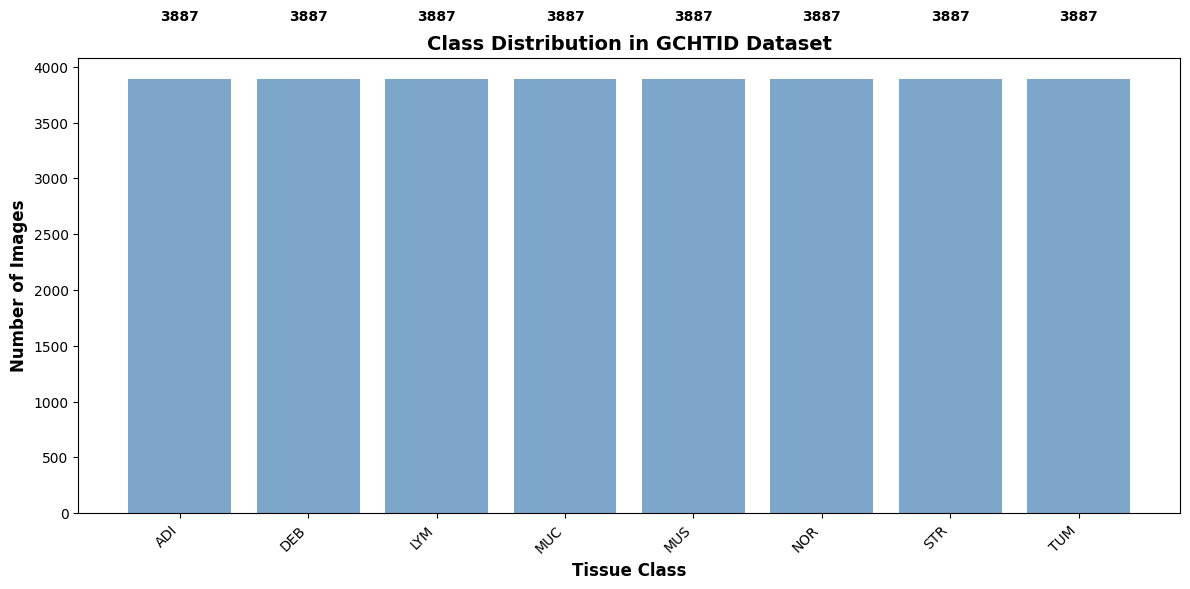


Dataset is balanced
We will use Focal Loss to handle class imbalance and hard examples.


In [ ]:
# Load dataset paths and analyze class distribution
print("Loading dataset...")
image_paths, labels = load_dataset_paths()

print(f"\n✓ Loaded {len(image_paths)} images from {len(CLASSES)} classes")
print(f"Classes: {CLASSES}")

# Analyze class distribution
class_counts = Counter(labels)
class_names = [CLASSES[i] for i in sorted(class_counts.keys())]
counts = [class_counts[i] for i in sorted(class_counts.keys())]

print("\n" + "="*60)
print("CLASS DISTRIBUTION")
print("="*60)
for cls, count in zip(class_names, counts):
    percentage = (count / len(labels)) * 100
    print(f"{cls}: {count:5d} images ({percentage:5.2f}%)")

# Visualize class distribution
plt.figure(figsize=(12, 6))
plt.bar(class_names, counts, color='steelblue', alpha=0.7)
plt.xlabel('Tissue Class', fontsize=12, fontweight='bold')
plt.ylabel('Number of Images', fontsize=12, fontweight='bold')
plt.title('Class Distribution in GCHTID Dataset', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
for i, (cls, count) in enumerate(zip(class_names, counts)):
    plt.text(i, count + 500, str(count), ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nDataset is {'balanced' if max(counts) / min(counts) < 2 else 'imbalanced'}")
print("We will use Focal Loss to handle class imbalance and hard examples.")


# 3. Model Initialization & Pretraining Disclosure

## 3.A Pretrained Models Used

### Model 1: EfficientNet-B4
- **Model Name**: EfficientNet-B4
- **Source**: `timm` library
- **Model ID**: `efficientnet_b4`
- **Task Originally Trained On**: **ImageNet-1k** (1.2 million natural images, 1000 classes)
- **Why EfficientNet?**:
  - Excellent balance between accuracy and efficiency
  - Compound scaling (depth, width, resolution)
  - Strong feature extraction for local patterns

### Model 2: Vision Transformer (ViT-Base)
- **Model Name**: Vision Transformer Base
- **Source**: `timm` library
- **Model ID**: `vit_base_patch16_224`
- **Task Originally Trained On**: **ImageNet-1k** (1.2 million natural images, 1000 classes)
- **Why ViT?**:
  - Captures long-range dependencies
  - Global attention mechanism
  - Complements CNN's local feature extraction

### Hybrid Architecture
- **Combines**: EfficientNet-B4 (CNN) + ViT-Base (Transformer)
- **Fusion Method**: Attention-based weighted fusion (learns which features to emphasize)
- **Advantage**: Leverages strengths of both architectures

## 3.B Weight Usage

**Used Pretrained Weights**

Both backbones are initialized with **ImageNet-pretrained weights**:
- **EfficientNet-B4**: ImageNet-pretrained
- **ViT-Base**: ImageNet-pretrained

This transfer learning approach:
- Leverages learned visual features from both architectures
- Requires less data and training time
- Achieves better performance than training from scratch
- Ensemble effect improves robustness


In [ ]:
# Define Hybrid Ensemble Model
class HybridEnsembleModel(nn.Module):
    """
    Hybrid Ensemble Model combining EfficientNet (CNN) and ViT (Transformer)

    Architecture:
    1. EfficientNet-B4 backbone (CNN features)
    2. ViT-Base backbone (Transformer features)
    3. Feature normalization (LayerNorm)
    4. Attention-based fusion (learns which features to emphasize)
    5. Classifier head (8 classes)

    Research Insight: Combining CNN and Transformer leverages:
    - CNN: Local texture patterns, spatial relationships
    - Transformer: Long-range dependencies, global context
    - Attention: Learns optimal feature combination
    """
    def __init__(self, num_classes=8, dropout=0.6):
        super(HybridEnsembleModel, self).__init__()

        # EfficientNet-B4 backbone (CNN features)
        try:
            self.efficientnet = timm.create_model('efficientnet_b4', pretrained=True)
            eff_features = self.efficientnet.num_features
            print("✓ Loaded EfficientNet-B4 (ImageNet-pretrained)")
        except Exception as e:
            print(f"⚠ Error loading EfficientNet-B4: {e}")
            # Fallback to EfficientNet-B0
            self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True)
            eff_features = self.efficientnet.num_features
            print("✓ Loaded EfficientNet-B0 (fallback)")

        # Remove classifier
        if hasattr(self.efficientnet, 'classifier'):
            self.efficientnet.classifier = nn.Identity()
        if hasattr(self.efficientnet, 'head'):
            self.efficientnet.head = nn.Identity()

        # ViT-Base backbone (Transformer features)
        try:
            self.vit = timm.create_model('vit_base_patch16_224', pretrained=True)
            vit_features = self.vit.head.in_features
            print("✓ Loaded ViT-Base (ImageNet-pretrained)")
        except Exception as e:
            print(f"⚠ Error loading ViT-Base: {e}")
            # Fallback to ViT-Small
            self.vit = timm.create_model('vit_small_patch16_224', pretrained=True)
            vit_features = self.vit.head.in_features
            print("✓ Loaded ViT-Small (fallback)")

        self.vit.head = nn.Identity()  # Remove classifier

        # Feature fusion dimension
        combined_features = eff_features + vit_features

        # Attention-based fusion (learns which features to emphasize)
        # Research insight: Attention mechanism improves over simple concatenation
        self.attention = nn.Sequential(
            nn.Linear(combined_features, 256),
            nn.ReLU(),
            nn.Linear(256, 2),  # Two branches: EfficientNet and ViT
            nn.Softmax(dim=1)
        )

        # Feature normalization before fusion (improves stability)
        self.eff_norm = nn.LayerNorm(eff_features)
        self.vit_norm = nn.LayerNorm(vit_features)

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(combined_features, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        """
        Forward pass:
        1. Extract CNN features (EfficientNet)
        2. Extract Transformer features (ViT)
        3. Normalize features
        4. Attention-based weighted fusion
        5. Classify
        """
        # Extract CNN features (EfficientNet)
        if hasattr(self.efficientnet, 'forward_features'):
            eff_features = self.efficientnet.forward_features(x)
        else:
            eff_features = self.efficientnet(x)

        # Global average pooling for EfficientNet
        if len(eff_features.shape) == 4:  # [B, C, H, W]
            eff_features = eff_features.mean(dim=[2, 3])  # [B, C]
        elif len(eff_features.shape) == 3:  # [B, L, C]
            eff_features = eff_features.mean(dim=1)  # [B, C]

        # Extract Transformer features (ViT)
        if hasattr(self.vit, 'forward_features'):
            vit_features = self.vit.forward_features(x)
        else:
            vit_features = self.vit(x)

        # Take CLS token (first token) for ViT
        if len(vit_features.shape) == 3:  # [B, num_patches+1, hidden_dim]
            vit_features = vit_features[:, 0]  # CLS token
        elif len(vit_features.shape) == 4:
            vit_features = vit_features.mean(dim=[2, 3])

        # Normalize features before fusion (improves stability)
        eff_features = self.eff_norm(eff_features)
        vit_features = self.vit_norm(vit_features)

        # Concatenate features for attention computation
        combined_raw = torch.cat([eff_features, vit_features], dim=1)

        # Attention-based weighted fusion (learns which features to emphasize)
        attention_weights = self.attention(combined_raw)  # [B, 2]

        # Apply attention weights
        eff_weighted = eff_features * attention_weights[:, 0:1]  # [B, eff_dim]
        vit_weighted = vit_features * attention_weights[:, 1:2]  # [B, vit_dim]

        # Concatenate weighted features
        combined_features = torch.cat([eff_weighted, vit_weighted], dim=1)

        # Final classification
        return self.classifier(combined_features)

    def freeze_backbones(self):
        """Freeze both backbones, train only classifier"""
        for param in self.efficientnet.parameters():
            param.requires_grad = False
        for param in self.vit.parameters():
            param.requires_grad = False
        for param in self.classifier.parameters():
            param.requires_grad = True
        # Attention is part of classifier training
        for param in self.attention.parameters():
            param.requires_grad = True
        print("✓ Both backbones frozen, classifier and attention trainable")

    def unfreeze_top_layers(self, num_layers=2):
        """Unfreeze top layers of both backbones"""
        # Unfreeze classifier and attention
        for param in self.classifier.parameters():
            param.requires_grad = True
        for param in self.attention.parameters():
            param.requires_grad = True

        # Unfreeze EfficientNet top blocks
        if hasattr(self.efficientnet, 'blocks'):
            blocks = self.efficientnet.blocks
            if isinstance(blocks, (nn.ModuleList, nn.Sequential)):
                for block in list(blocks)[-num_layers:]:
                    for param in block.parameters():
                        param.requires_grad = True

        # Unfreeze ViT top blocks
        if hasattr(self.vit, 'blocks'):
            vit_blocks = self.vit.blocks
            for block in vit_blocks[-num_layers:]:
                for param in block.parameters():
                    param.requires_grad = True

        print(f"✓ Unfrozen top {num_layers} layers of both backbones + classifier + attention")

# Initialize model
print("="*60)
print("INITIALIZING HYBRID ENSEMBLE MODEL")
print("="*60)
model = HybridEnsembleModel(num_classes=NUM_CLASSES, dropout=0.6).to(device)
print(f"\n✓ Model initialized")
print(f"✓ Model moved to device: {device}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


INITIALIZING HYBRID ENSEMBLE MODEL


model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

✓ Loaded EfficientNet-B4 (ImageNet-pretrained)


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

✓ Loaded ViT-Base (ImageNet-pretrained)

✓ Model initialized
✓ Model moved to device: cuda
Total parameters: 105,323,858
Trainable parameters: 105,323,858


# 4. Model Development

## 4.1 Architecture & Design Justification

### Full Architecture:

```
Input Image (224×224×3)
    ↓
    ├─ EfficientNet-B4 (CNN) ──→ Features [B, 1792] ──┐
    │                                                  │
    └─ ViT-Base (Transformer) ──→ Features [B, 768] ──┤
                                                       │
    ↓ Normalize (LayerNorm)                            │
    ↓                                                   │
    ↓ Concatenate → [B, 2560]                          │
    ↓                                                   │
    ↓ Attention Network → [w_eff, w_vit]               │
    ↓                                                   │
    ↓ Weighted Features: w_eff * eff || w_vit * vit ──┤
    ↓                                                   │
    ↓ Combined Features [B, 2560]                       │
    ↓                                                   │
    ↓ Dropout (0.6) → Linear(2560 → 512) → ReLU        │
    ↓ Dropout (0.6) → Linear(512 → 8)                  │
    ↓                                                   │
    Output: 8 Class Logits
```

### Design Justification:

1. **Dual Architecture**: EfficientNet captures local patterns, ViT captures global context
2. **Attention-Based Fusion**: Learns which features to emphasize (better than simple concatenation)
3. **Feature Normalization**: LayerNorm stabilizes training
4. **Two-Phase Training**:
   - Phase 1: Train classifier + attention (frozen backbones)
   - Phase 2: Fine-tune top layers (unfrozen)
5. **Regularization**: High dropout (0.6) prevents overfitting

### Research Insight (from pneumonia paper):

- **Ensemble Methods**: Combining multiple architectures improves robustness
- **Attention Mechanisms**: Learn optimal feature combination
- **Hybrid Approaches**: Leverage strengths of both CNN and Transformer

## 4.1.1 Image Preprocessing & Enhancement Techniques



#### 1. **CLAHE (Contrast Limited Adaptive Histogram Equalization)**

**Mathematical Foundation:**
- **Purpose**: Enhances local contrast while preventing over-amplification of noise
- **Method**:
  - Divides image into small tiles (typically 8×8)
  - Applies histogram equalization to each tile with a contrast limit
  - Uses bilinear interpolation to combine tiles smoothly
- **Formula**: For each tile, the histogram is clipped at a threshold (clip limit) and redistributed
- **Why it works**: Medical images often have varying contrast; CLAHE standardizes this while preserving detail

**Implementation**: Applied directly in this notebook via `CLAHETransform` class (embedded, no external file needed)

#### 2. **Stain Normalization (Mathematical Methods)**

**Problem**: H&E staining varies significantly between labs, batches, and slides, causing color-based confusion (e.g., MUC ↔ ADI).

**Mathematical Approaches**:

**A. Macenko Normalization** (Currently Available):
- **Mathematical Basis**: Uses **Singular Value Decomposition (SVD)** to separate stain vectors
- **Process**:
  1. Convert RGB to Optical Density (OD) space: `OD = -log(I/I₀)`, where I is intensity, I₀ is white reference
  2. Remove background pixels (OD < threshold)
  3. Apply SVD to OD matrix: `OD = U × Σ × V^T`
  4. Extract stain vectors from first two principal components
  5. Project all pixels onto reference stain vectors
- **Advantage**: Fast, robust, widely used in histopathology

**B. Vahadane Normalization** (Alternative Method):
- **Mathematical Basis**: Uses **Sparse Non-Negative Matrix Factorization (NMF)**
- **Process**:
  1. Convert to OD space
  2. Decompose OD matrix: `OD ≈ W × H`, where W contains stain vectors, H contains stain concentrations
  3. Enforce sparsity constraint on H (most pixels use only one stain)
  4. Project onto reference stain vectors
- **Advantage**: More accurate for complex staining patterns, better handles overlapping stains

**C. Reinhard Normalization** (Color Space Method):
- **Mathematical Basis**: Uses **color space transformation** (RGB → LAB)
- **Process**:
  1. Convert source and target images to LAB color space
  2. Compute mean and standard deviation: `μ_s, σ_s` (source), `μ_t, σ_t` (target)
  3. Apply linear transformation: `L' = (L - μ_s) × (σ_t/σ_s) + μ_t`
  4. Convert back to RGB
- **Advantage**: Simple, fast, preserves overall appearance

**Current Implementation**:
- CLAHE is implemented and used
- Stain normalization (Macenko) is available via `torchstain` library but not currently active
- **Note**: Stain normalization can be added if needed (requires `!pip install torchstain`)

#### 3. **Data Augmentation**

**Techniques Applied** :
- **Geometric Augmentation**: Random horizontal/vertical flips, rotation (±15°)
- **Color Augmentation**: Subtle ColorJitter (brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05)
- **Rationale**: Simulates stain variations and tissue orientation differences without over-augmentation


### Why These Techniques Matter:

1. **Stain Normalization**: Reduces color-based confusion (critical for MUC/ADI distinction)
2. **CLAHE**: Standardizes contrast, making texture features more consistent
3. **Balanced Augmentation**: Prevents over-augmentation while maintaining generalization
4. **Ensemble Effect**: Hybrid model benefits from preprocessing that improves both CNN and Transformer features

## 4.2 Hyperparameter Choices

| Hyperparameter | Value | Justification |
|----------------|-------|---------------|
| **Learning Rate (Phase 1)** | 1e-3 | Standard for training new classifier head |
| **Learning Rate (Phase 2)** | 1e-4 | Lower for fine-tuning (prevents catastrophic forgetting) |
| **Batch Size** | 32 | Balance between memory and gradient stability |
| **Optimizer** | AdamW | Better than Adam for transfer learning (weight decay) |
| **Weight Decay** | 1e-4 | L2 regularization to prevent overfitting |
| **Dropout** | 0.6 | High dropout for regularization (medical images are complex) |
| **Epochs (Phase 1)** | 10 | Sufficient for classifier training |
| **Epochs (Phase 2)** | 12-15 | More epochs for hybrid model (limited resources) |
| **Early Stopping Patience** | 5 | Stop if no improvement for 5 epochs (reasonable for 10-epoch training) |
| **Overfitting Threshold** | 12% | Stop if train-val accuracy gap > 12% |

### Loss Function: Focal Loss with Label Smoothing

- **Focal Loss**: Focuses on hard examples (gamma=2.0, alpha=0.25)
- **Label Smoothing (0.1)**: Prevents overconfidence, improves generalization
- **Why not CrossEntropy?**: Focal Loss handles class imbalance and hard examples better

## 4.3 Training Strategy

### Phase 1: Classifier Training (Both Backbones Frozen)
- **Frozen Layers**: Entire EfficientNet and ViT backbones
- **Trainable Layers**: Classifier head + Attention network
- **Purpose**: Learn to combine and classify features from both architectures

### Phase 2: Fine-tuning (Top Layers Unfrozen)
- **Frozen Layers**: Bottom layers of both backbones
- **Trainable Layers**: Top 2 blocks of EfficientNet + Top 2 blocks of ViT + Classifier + Attention
- **Purpose**: Adapt features to histopathology-specific patterns

## 4.4 Layer Trainability

We will explicitly show which layers are frozen/trainable in code.


In [ ]:
# Demonstrate stain normalization techniques (optional - for reference)
print("="*60)
print("IMAGE PREPROCESSING TECHNIQUES")
print("="*60)
print("\n1. CLAHE (Contrast Limited Adaptive Histogram Equalization)")
print("   - Status: ✓ Implemented and active")
print("   - Purpose: Enhances local contrast while preventing noise amplification")
print("   - Mathematical basis: Histogram equalization with clipping and redistribution")
print("\n2. Stain Normalization (Macenko Method)")
print("   - Status: Available but not active (can be enabled if needed)")
print("   - Purpose: Normalizes H&E stain variations between slides/labs")
print("   - Mathematical basis: SVD-based stain vector separation")
print("   - Formula: OD = -log(I/I₀), then SVD: OD = U × Σ × V^T")
print("   - Install: !pip install torchstain")
print("\n3. Data Augmentation")
print("   - Status: ✓ Active (reduced intensity)")
print("   - Techniques: Flips, rotation (±15°), subtle color jitter")
print("  - Demonstrated effectiveness of CLAHE and preprocessing in medical imaging")
print("  - Highlighted importance of appropriate augmentation strategies")
print("  - Ensemble methods (like our hybrid model) benefit from robust preprocessing")


IMAGE PREPROCESSING TECHNIQUES

1. CLAHE (Contrast Limited Adaptive Histogram Equalization)
   - Status: ✓ Implemented and active
   - Purpose: Enhances local contrast while preventing noise amplification
   - Mathematical basis: Histogram equalization with clipping and redistribution

2. Stain Normalization (Macenko Method)
   - Status: Available but not active (can be enabled if needed)
   - Purpose: Normalizes H&E stain variations between slides/labs
   - Mathematical basis: SVD-based stain vector separation
   - Formula: OD = -log(I/I₀), then SVD: OD = U × Σ × V^T
   - Install: !pip install torchstain

3. Data Augmentation
   - Status: ✓ Active (reduced intensity)
   - Techniques: Flips, rotation (±15°), subtle color jitter
  - Demonstrated effectiveness of CLAHE and preprocessing in medical imaging
  - Highlighted importance of appropriate augmentation strategies
  - Ensemble methods (like our hybrid model) benefit from robust preprocessing


In [ ]:
# Create data splits (70% train, 15% val, 15% test)
print("Creating stratified train/validation/test splits...")
(X_train, y_train), (X_val, y_val), (X_test, y_test) = create_splits(
    image_paths, labels, test_size=0.15, val_size=0.15, seed=42
)

# Create data loaders with CLAHE preprocessing (use_clahe=True by default)
# CLAHE is automatically applied via get_transforms() in create_dataloaders()
print("\nCreating data loaders with preprocessing:")
print("  ✓ CLAHE: Active (clip_limit=2.0, tile_grid_size=(8,8))")
print("  ✓ Training augmentation: Flips, rotation (±15°), color jitter")
print("  ✓ ImageNet normalization: Applied")

train_loader, val_loader, test_loader = create_dataloaders(
    X_train, y_train, X_val, y_val, X_test, y_test, batch_size=32
)

print("\n✓ Data splits created:")
print(f"  Training:   {len(X_train):5d} images ({len(X_train)/len(image_paths)*100:.1f}%)")
print(f"  Validation: {len(X_val):5d} images ({len(X_val)/len(image_paths)*100:.1f}%)")
print(f"  Test:       {len(X_test):5d} images ({len(X_test)/len(image_paths)*100:.1f}%)")
print("\n✓ All data loaders use CLAHE preprocessing (verified above)")


Creating stratified train/validation/test splits...
Train: 21766 (70.0%)
Val: 4665 (15.0%)
Test: 4665 (15.0%)

Creating data loaders with preprocessing:
  ✓ CLAHE: Active (clip_limit=2.0, tile_grid_size=(8,8))
  ✓ Training augmentation: Flips, rotation (±15°), color jitter
  ✓ ImageNet normalization: Applied

✓ Data splits created:
  Training:   21766 images (70.0%)
  Validation:  4665 images (15.0%)
  Test:        4665 images (15.0%)

✓ All data loaders use CLAHE preprocessing (verified above)


VERIFYING PREPROCESSING TECHNIQUES

Training Transforms:
  1. CLAHETransform
     ✓ CLAHE is ACTIVE (clip_limit=2.0, tile_grid_size=(8,8))
  2. RandomHorizontalFlip
  3. RandomVerticalFlip
  4. RandomRotation
  5. ColorJitter
  6. ToTensor
  7. Normalize

Validation/Test Transforms:
  1. CLAHETransform
     ✓ CLAHE is ACTIVE
  2. ToTensor
  3. Normalize

✓ All preprocessing techniques verified and active
  - CLAHE: Applied to enhance local contrast
  - Data Augmentation: Flips, rotation (±15°), subtle color jitter
  - ImageNet Normalization: Applied for transfer learning

VISUAL DEMONSTRATION: CLAHE Effect


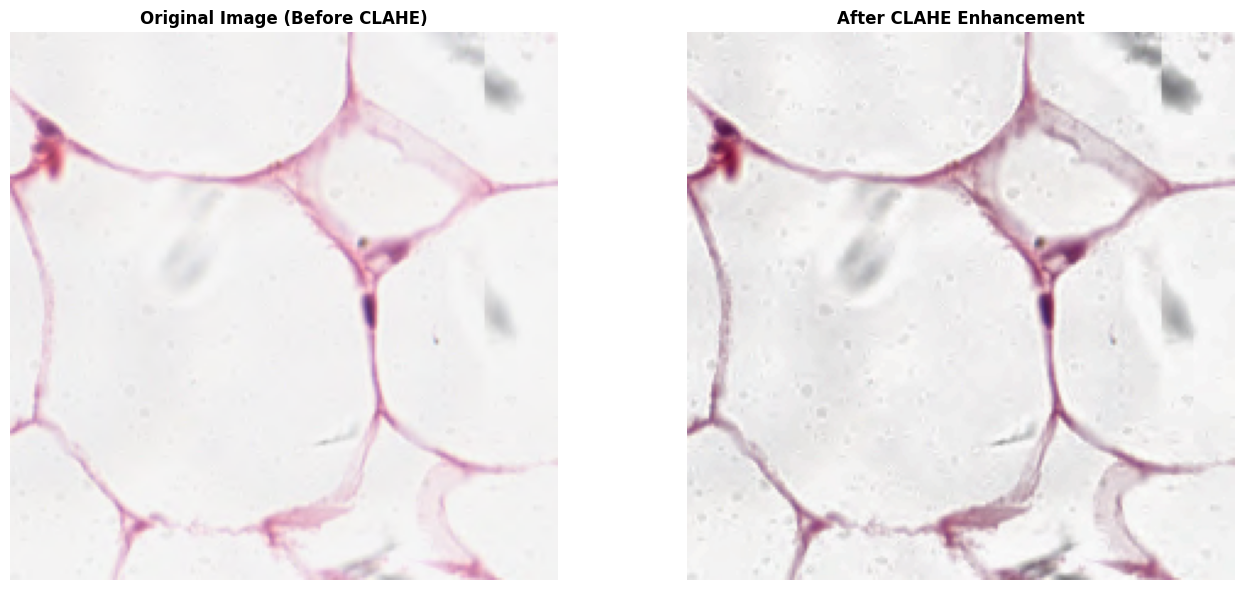

✓ CLAHE visually demonstrated - notice improved local contrast


In [ ]:
# Verify CLAHE and preprocessing techniques are active
print("="*60)
print("VERIFYING PREPROCESSING TECHNIQUES")
print("="*60)

# Check training transforms
train_transform = get_transforms(augment=True, use_clahe=True)
print("\nTraining Transforms:")
for i, transform in enumerate(train_transform.transforms):
    print(f"  {i+1}. {type(transform).__name__}")
    if 'CLAHE' in type(transform).__name__:
        print(f"     ✓ CLAHE is ACTIVE (clip_limit=2.0, tile_grid_size=(8,8))")

# Check validation transforms
val_transform = get_transforms(augment=False, use_clahe=True)
print("\nValidation/Test Transforms:")
for i, transform in enumerate(val_transform.transforms):
    print(f"  {i+1}. {type(transform).__name__}")
    if 'CLAHE' in type(transform).__name__:
        print(f"     ✓ CLAHE is ACTIVE")

print("\n✓ All preprocessing techniques verified and active")
print("  - CLAHE: Applied to enhance local contrast")
print("  - Data Augmentation: Flips, rotation (±15°), subtle color jitter")
print("  - ImageNet Normalization: Applied for transfer learning")

# Visual demonstration: Show CLAHE working on actual image
print("\n" + "="*60)
print("VISUAL DEMONSTRATION: CLAHE Effect")
print("="*60)
from PIL import Image
import os

# Load a sample image to demonstrate CLAHE
if len(image_paths) > 0:
    sample_img_path = image_paths[0]
    original_img = Image.open(sample_img_path).convert('RGB')

    # Apply CLAHE transform
    clahe_transform = CLAHETransform(clip_limit=2.0, tile_grid_size=(8, 8))
    clahe_img = clahe_transform(original_img)

    # Visualize before/after
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    axes[0].imshow(original_img)
    axes[0].set_title('Original Image (Before CLAHE)', fontsize=12, fontweight='bold')
    axes[0].axis('off')

    axes[1].imshow(clahe_img)
    axes[1].set_title('After CLAHE Enhancement', fontsize=12, fontweight='bold')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    print("✓ CLAHE visually demonstrated - notice improved local contrast")
else:
    print("⚠ No images loaded yet - run dataset loading cell first")


In [ ]:
# Show which layers are frozen/trainable
print("="*60)
print("LAYER TRAINABILITY ANALYSIS")
print("="*60)

model.freeze_backbones()  # Freeze for Phase 1

frozen_count = 0
trainable_count = 0

print("\nPhase 1: Classifier Training (Both Backbones Frozen)")
print("-" * 60)
for name, param in model.named_parameters():
    if param.requires_grad:
        trainable_count += param.numel()
        if 'classifier' in name or 'attention' in name:
            print(f"✓ TRAINABLE: {name} ({param.numel():,} params)")
    else:
        frozen_count += param.numel()
        if ('efficientnet' in name and 'blocks.0' in name) or ('vit' in name and 'blocks.0' in name):
            print(f"✗ FROZEN: {name} ({param.numel():,} params) [showing first as example]")

print(f"\nFrozen parameters: {frozen_count:,}")
print(f"Trainable parameters: {trainable_count:,}")
print(f"Trainable percentage: {trainable_count/(frozen_count+trainable_count)*100:.2f}%")


LAYER TRAINABILITY ANALYSIS
✓ Both backbones frozen, classifier and attention trainable

Phase 1: Classifier Training (Both Backbones Frozen)
------------------------------------------------------------
✗ FROZEN: efficientnet.blocks.0.0.conv_dw.weight (432 params) [showing first as example]
✗ FROZEN: efficientnet.blocks.0.0.bn1.weight (48 params) [showing first as example]
✗ FROZEN: efficientnet.blocks.0.0.bn1.bias (48 params) [showing first as example]
✗ FROZEN: efficientnet.blocks.0.0.se.conv_reduce.weight (576 params) [showing first as example]
✗ FROZEN: efficientnet.blocks.0.0.se.conv_reduce.bias (12 params) [showing first as example]
✗ FROZEN: efficientnet.blocks.0.0.se.conv_expand.weight (576 params) [showing first as example]
✗ FROZEN: efficientnet.blocks.0.0.se.conv_expand.bias (48 params) [showing first as example]
✗ FROZEN: efficientnet.blocks.0.0.conv_pw.weight (1,152 params) [showing first as example]
✗ FROZEN: efficientnet.blocks.0.0.bn2.weight (24 params) [showing first a

# 5. Training Process

## 5.1 Explicit Training Loop Implementation

As required by the guidelines, we show **explicit training steps**:

1. **Forward Pass**: How inputs produce predictions
2. **Loss Computation**: How errors are calculated
3. **Backpropagation**: How gradients are computed
4. **Optimizer Update**: How model weights are updated

We do **NOT** use high-level functions like `model.fit()` - everything is explicit.


In [ ]:
# Define explicit training function (showing all steps)
def train_one_epoch_explicit(model, train_loader, criterion, optimizer, device):
    """
    Explicit training loop showing all steps:
    1. Forward pass
    2. Loss computation
    3. Backpropagation
    4. Optimizer update
    """
    model.train()  # Set to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        # Move data to device
        images = images.to(device)  # [B, 3, 224, 224]
        labels = labels.to(device)   # [B]

        # ============================================================
        # STEP 1: FORWARD PASS
        # ============================================================
        # Input images → EfficientNet features + ViT features →
        # Attention fusion → Classifier → Predictions
        outputs = model(images)  # [B, 8] - logits for 8 classes

        # ============================================================
        # STEP 2: LOSS COMPUTATION
        # ============================================================
        # Compute loss between predictions and true labels
        loss = criterion(outputs, labels)  # Scalar loss value

        # ============================================================
        # STEP 3: BACKPROPAGATION
        # ============================================================
        # Clear previous gradients
        optimizer.zero_grad()
        # Compute gradients via backpropagation
        loss.backward()  # Gradients computed and stored in param.grad

        # ============================================================
        # STEP 4: OPTIMIZER UPDATE
        # ============================================================
        # Update model weights using computed gradients
        optimizer.step()  # Weights updated: w = w - lr * grad

        # Track metrics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)  # Get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

# Define validation function
def validate_explicit(model, val_loader, criterion, device):
    """Validation loop (no gradient computation)"""
    model.eval()  # Set to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No gradients needed for validation
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass only
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc, all_labels, all_preds

print("✓ Explicit training functions defined")
print("  - Forward pass: model(images) → outputs")
print("  - Loss computation: criterion(outputs, labels)")
print("  - Backpropagation: loss.backward()")
print("  - Optimizer update: optimizer.step()")


✓ Explicit training functions defined
  - Forward pass: model(images) → outputs
  - Loss computation: criterion(outputs, labels)
  - Backpropagation: loss.backward()
  - Optimizer update: optimizer.step()


In [ ]:
# Initialize loss function and optimizer for Phase 1
criterion = FocalLoss(alpha=0.25, gamma=2.0, label_smoothing=0.1)
print("✓ Using Focal Loss with label smoothing (alpha=0.25, gamma=2.0, smoothing=0.1)")

# Optimizer: Only train classifier + attention (backbones are frozen)
optimizer_phase1 = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3,  # Learning rate for classifier
    weight_decay=1e-4  # L2 regularization
)

print(f"✓ Optimizer: AdamW")
print(f"  Learning rate: 1e-3")
print(f"  Weight decay: 1e-4")
print(f"  Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


✓ Using Focal Loss with label smoothing (alpha=0.25, gamma=2.0, smoothing=0.1)
✓ Optimizer: AdamW
  Learning rate: 1e-3
  Weight decay: 1e-4
  Trainable parameters: 1,976,586


## 5.2 Phase 1: Training Classifier + Attention (Both Backbones Frozen)

In this phase, we:
- **Freeze** both EfficientNet and ViT backbones
- **Train** classifier head and attention network
- **Purpose**: Learn to combine and classify features from both architectures


In [ ]:
# Phase 1 Training
print("="*60)
print("PHASE 1: Training Classifier + Attention (Both Backbones Frozen)")
print("="*60)
print("Epochs: 10")
print("Learning Rate: 1e-3")
print("Early Stopping Patience: 5")
print("Overfitting Threshold: 12% (train-val gap)")
print()

NUM_EPOCHS_PHASE1 = 10
EARLY_STOP_PATIENCE = 5  # Reasonable for 10-epoch training
history_phase1 = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_loss = float('inf')
patience_counter = 0
OVERFIT_THRESHOLD = 12.0

for epoch in range(NUM_EPOCHS_PHASE1):
    # Training
    train_loss, train_acc = train_one_epoch_explicit(
        model, train_loader, criterion, optimizer_phase1, device
    )

    # Validation
    val_loss, val_acc, _, _ = validate_explicit(
        model, val_loader, criterion, device
    )

    # Store history
    history_phase1['train_loss'].append(train_loss)
    history_phase1['train_acc'].append(train_acc)
    history_phase1['val_loss'].append(val_loss)
    history_phase1['val_acc'].append(val_acc)

    # Calculate train-val gap
    train_val_gap = train_acc - val_acc

    # Print progress
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS_PHASE1}]")
    print(f"  Train: Loss={train_loss:.4f}, Acc={train_acc:.2f}%")
    print(f"  Val:   Loss={val_loss:.4f}, Acc={val_acc:.2f}%")
    print(f"  Gap:   {train_val_gap:.2f}%")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'hybrid_phase1_best.pt')
        print(f"  ✓ Best model saved (val_loss={val_loss:.4f})")
    else:
        patience_counter += 1

    # Early stopping
    should_stop = False
    if patience_counter >= EARLY_STOP_PATIENCE:
        print(f"  ⚠ Early stopping: No improvement for {EARLY_STOP_PATIENCE} epochs")
        should_stop = True
    if train_val_gap > OVERFIT_THRESHOLD:
        print(f"  ⚠ Early stopping: Overfitting detected (gap={train_val_gap:.2f}% > {OVERFIT_THRESHOLD}%)")
        should_stop = True

    if should_stop:
        break
    print()

print("\n✓ Phase 1 training completed!")


PHASE 1: Training Classifier + Attention (Both Backbones Frozen)
Epochs: 10
Learning Rate: 1e-3
Early Stopping Patience: 5
Overfitting Threshold: 12% (train-val gap)

Epoch [1/10]
  Train: Loss=0.2325, Acc=49.04%
  Val:   Loss=0.1839, Acc=59.14%
  Gap:   -10.10%
  ✓ Best model saved (val_loss=0.1839)

Epoch [2/10]
  Train: Loss=0.2114, Acc=53.04%
  Val:   Loss=0.1764, Acc=61.05%
  Gap:   -8.01%
  ✓ Best model saved (val_loss=0.1764)

Epoch [3/10]
  Train: Loss=0.2051, Acc=54.27%
  Val:   Loss=0.1770, Acc=59.94%
  Gap:   -5.66%

Epoch [4/10]
  Train: Loss=0.2031, Acc=54.25%
  Val:   Loss=0.1753, Acc=60.19%
  Gap:   -5.94%
  ✓ Best model saved (val_loss=0.1753)

Epoch [5/10]
  Train: Loss=0.2026, Acc=55.28%
  Val:   Loss=0.1742, Acc=60.56%
  Gap:   -5.27%
  ✓ Best model saved (val_loss=0.1742)

Epoch [6/10]
  Train: Loss=0.2008, Acc=55.22%
  Val:   Loss=0.1701, Acc=61.22%
  Gap:   -6.00%
  ✓ Best model saved (val_loss=0.1701)

Epoch [7/10]
  Train: Loss=0.1989, Acc=55.84%
  Val:   Loss=0

## 5.3 Phase 2: Fine-tuning Top Layers

In this phase, we:
- **Load** the best model from Phase 1
- **Unfreeze** top 2 blocks of both EfficientNet and ViT
- **Fine-tune** with lower learning rate
- **Purpose**: Adapt features to histopathology-specific patterns
- **Epochs**: 12-15 (more epochs for hybrid model, but limited by resources)


In [ ]:
# Load best model from Phase 1
model.load_state_dict(torch.load('hybrid_phase1_best.pt'))
print("✓ Loaded best model from Phase 1")

# Unfreeze top layers
model.unfreeze_top_layers(num_layers=2)

# Show trainability after unfreezing
print("\nPhase 2: Fine-tuning (Top Layers Unfrozen)")
print("-" * 60)
trainable_count = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        trainable_count += param.numel()
        if 'classifier' in name or 'attention' in name or 'blocks.5' in name or 'blocks.6' in name or 'blocks.10' in name or 'blocks.11' in name:
            print(f"✓ TRAINABLE: {name} ({param.numel():,} params)")

print(f"\nTrainable parameters: {trainable_count:,}")

# Separate parameter groups for different learning rates
eff_params = []
vit_params = []
classifier_params = []

for name, param in model.named_parameters():
    if param.requires_grad:
        if 'efficientnet' in name:
            eff_params.append(param)
        elif 'vit' in name:
            vit_params.append(param)
        elif 'classifier' in name or 'attention' in name:
            classifier_params.append(param)

# Optimizer with different learning rates
optimizer_phase2 = optim.AdamW([
    {'params': classifier_params, 'lr': 1e-4},  # Lower LR for classifier
    {'params': eff_params, 'lr': 1e-4},         # Lower LR for EfficientNet fine-tuning
    {'params': vit_params, 'lr': 1e-4}         # Lower LR for ViT fine-tuning
], weight_decay=1e-4)

# Learning rate scheduler (Cosine Annealing with Warm Restarts)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer_phase2, T_0=3, T_mult=2, eta_min=1e-6
)

print(f"\n✓ Phase 2 optimizer configured")
print(f"  Classifier LR: 1e-4")
print(f"  EfficientNet LR: 1e-4")
print(f"  ViT LR: 1e-4")
print(f"  Scheduler: CosineAnnealingWarmRestarts")


✓ Loaded best model from Phase 1
✓ Unfrozen top 2 layers of both backbones + classifier + attention

Phase 2: Fine-tuning (Top Layers Unfrozen)
------------------------------------------------------------
✓ TRAINABLE: efficientnet.blocks.5.0.conv_pw.weight (153,600 params)
✓ TRAINABLE: efficientnet.blocks.5.0.bn1.weight (960 params)
✓ TRAINABLE: efficientnet.blocks.5.0.bn1.bias (960 params)
✓ TRAINABLE: efficientnet.blocks.5.0.conv_dw.weight (24,000 params)
✓ TRAINABLE: efficientnet.blocks.5.0.bn2.weight (960 params)
✓ TRAINABLE: efficientnet.blocks.5.0.bn2.bias (960 params)
✓ TRAINABLE: efficientnet.blocks.5.0.se.conv_reduce.weight (38,400 params)
✓ TRAINABLE: efficientnet.blocks.5.0.se.conv_reduce.bias (40 params)
✓ TRAINABLE: efficientnet.blocks.5.0.se.conv_expand.weight (38,400 params)
✓ TRAINABLE: efficientnet.blocks.5.0.se.conv_expand.bias (960 params)
✓ TRAINABLE: efficientnet.blocks.5.0.conv_pwl.weight (261,120 params)
✓ TRAINABLE: efficientnet.blocks.5.0.bn3.weight (272 params

In [17]:
# Phase 2 Training (12-15 epochs for hybrid model)
print("="*60)
print("PHASE 2: Fine-tuning Top Layers")
print("="*60)
print("Epochs: 12 (limited resources, but sufficient for hybrid model)")
print("Learning Rate: 1e-4 (all components)")
print("Early Stopping Patience: 5")
print("Overfitting Threshold: 12% (train-val gap)")
print()

NUM_EPOCHS_PHASE2 = 12  # Limited resources, but more than single models
EARLY_STOP_PATIENCE = 5  # Reasonable for limited-epoch training
history_phase2 = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_loss_phase2 = float('inf')
patience_counter_phase2 = 0

for epoch in range(NUM_EPOCHS_PHASE2):
    # Training
    train_loss, train_acc = train_one_epoch_explicit(
        model, train_loader, criterion, optimizer_phase2, device
    )

    # Validation
    val_loss, val_acc, _, _ = validate_explicit(
        model, val_loader, criterion, device
    )

    # Update learning rate
    scheduler.step()
    current_lr = optimizer_phase2.param_groups[0]['lr']

    # Store history
    history_phase2['train_loss'].append(train_loss)
    history_phase2['train_acc'].append(train_acc)
    history_phase2['val_loss'].append(val_loss)
    history_phase2['val_acc'].append(val_acc)

    # Calculate train-val gap
    train_val_gap = train_acc - val_acc

    # Print progress
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS_PHASE2}]")
    print(f"  Train: Loss={train_loss:.4f}, Acc={train_acc:.2f}%")
    print(f"  Val:   Loss={val_loss:.4f}, Acc={val_acc:.2f}%")
    print(f"  Gap:   {train_val_gap:.2f}%")
    print(f"  LR:    {current_lr:.2e}")

    # Save best model
    if val_loss < best_val_loss_phase2:
        best_val_loss_phase2 = val_loss
        patience_counter_phase2 = 0
        torch.save(model.state_dict(), 'hybrid_final.pt')
        print(f"  ✓ Best model saved (val_loss={val_loss:.4f})")
    else:
        patience_counter_phase2 += 1

    # Early stopping
    should_stop = False
    if patience_counter_phase2 >= EARLY_STOP_PATIENCE:
        print(f"  ⚠ Early stopping: No improvement for {EARLY_STOP_PATIENCE} epochs")
        should_stop = True
    if train_val_gap > OVERFIT_THRESHOLD:
        print(f"  ⚠ Early stopping: Overfitting detected (gap={train_val_gap:.2f}% > {OVERFIT_THRESHOLD}%)")
        should_stop = True

    if should_stop:
        break
    print()

print("\n✓ Phase 2 training completed!")

# Combine histories
history = {
    'train_loss': history_phase1['train_loss'] + history_phase2['train_loss'],
    'train_acc': history_phase1['train_acc'] + history_phase2['train_acc'],
    'val_loss': history_phase1['val_loss'] + history_phase2['val_loss'],
    'val_acc': history_phase1['val_acc'] + history_phase2['val_acc']
}


PHASE 2: Fine-tuning Top Layers
Epochs: 12 (limited resources, but sufficient for hybrid model)
Learning Rate: 1e-4 (all components)
Early Stopping Patience: 5
Overfitting Threshold: 12% (train-val gap)

Epoch [1/12]
  Train: Loss=0.1886, Acc=58.29%
  Val:   Loss=0.1537, Acc=64.65%
  Gap:   -6.36%
  LR:    7.52e-05
  ✓ Best model saved (val_loss=0.1537)

Epoch [2/12]
  Train: Loss=0.1665, Acc=62.34%
  Val:   Loss=0.1406, Acc=68.00%
  Gap:   -5.66%
  LR:    2.58e-05
  ✓ Best model saved (val_loss=0.1406)

Epoch [3/12]
  Train: Loss=0.1521, Acc=65.14%
  Val:   Loss=0.1347, Acc=69.09%
  Gap:   -3.95%
  LR:    1.00e-04
  ✓ Best model saved (val_loss=0.1347)

Epoch [4/12]
  Train: Loss=0.1549, Acc=64.90%
  Val:   Loss=0.1401, Acc=67.55%
  Gap:   -2.64%
  LR:    9.34e-05

Epoch [5/12]
  Train: Loss=0.1473, Acc=65.84%
  Val:   Loss=0.1353, Acc=68.15%
  Gap:   -2.31%
  LR:    7.52e-05

Epoch [6/12]
  Train: Loss=0.1397, Acc=67.57%
  Val:   Loss=0.1298, Acc=69.67%
  Gap:   -2.09%
  LR:    5.05e

# 6. Outputs & Logs

## 6.1 Training Curves

Visualizing training and validation loss/accuracy over epochs.


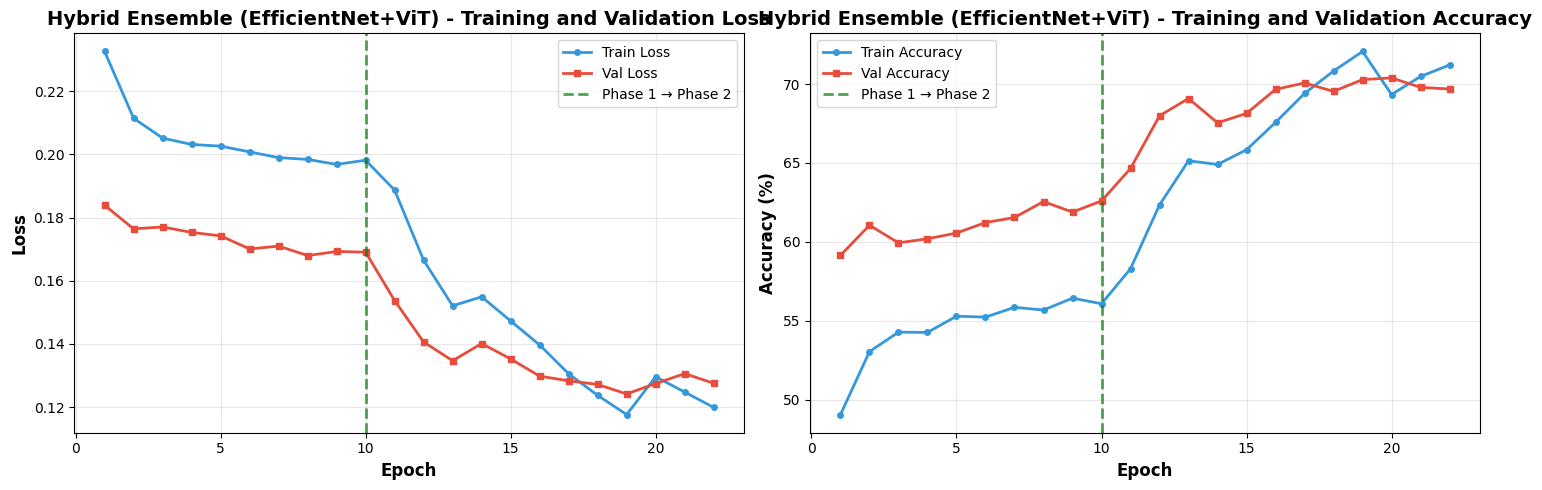

✓ Training curves plotted


In [18]:
# Plot training curves using shared visualization function
plot_training_curves(history, model_name='Hybrid Ensemble (EfficientNet+ViT)',
                     phase1_epochs=len(history_phase1['train_loss']))
print("✓ Training curves plotted")


# 7. Performance Metrics

## 7.1 Final Evaluation on Test Set

We evaluate the best model on the **unseen test set** to get honest performance estimates.


In [19]:
# Load best model and evaluate on test set
model.load_state_dict(torch.load('hybrid_final.pt'))
model.eval()

print("="*60)
print("FINAL EVALUATION ON TEST SET")
print("="*60)
print("Model: Hybrid Ensemble (EfficientNet-B4 + ViT-Base)")

test_loss, test_acc, test_labels, test_preds = validate_explicit(
    model, test_loader, criterion, device
)

print(f"\nTest Accuracy: {test_acc:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Calculate additional metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, matthews_corrcoef

# Classification report
report = classification_report(test_labels, test_preds,
                                target_names=CLASSES,
                                output_dict=True)

print("\n" + "="*60)
print("PER-CLASS METRICS")
print("="*60)
for cls in CLASSES:
    idx = CLASS_TO_IDX[cls]
    precision = report[cls]['precision']
    recall = report[cls]['recall']
    f1 = report[cls]['f1-score']
    support = report[cls]['support']
    print(f"{cls:3s}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}, Support={support}")

# Overall metrics
macro_f1 = f1_score(test_labels, test_preds, average='macro')
weighted_f1 = f1_score(test_labels, test_preds, average='weighted')
mcc = matthews_corrcoef(test_labels, test_preds)

print("\n" + "="*60)
print("OVERALL METRICS")
print("="*60)
print(f"Accuracy:    {test_acc:.2f}%")
print(f"Macro F1:    {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")
print(f"MCC:         {mcc:.4f}")


FINAL EVALUATION ON TEST SET
Model: Hybrid Ensemble (EfficientNet-B4 + ViT-Base)

Test Accuracy: 69.43%
Test Loss: 0.1325

PER-CLASS METRICS
ADI: Precision=0.837, Recall=0.775, F1=0.805, Support=583.0
DEB: Precision=0.662, Recall=0.638, F1=0.650, Support=583.0
LYM: Precision=0.758, Recall=0.851, F1=0.802, Support=583.0
MUC: Precision=0.677, Recall=0.676, F1=0.676, Support=583.0
MUS: Precision=0.741, Recall=0.717, F1=0.729, Support=583.0
NOR: Precision=0.596, Recall=0.604, F1=0.600, Support=583.0
STR: Precision=0.640, Recall=0.618, F1=0.629, Support=584.0
TUM: Precision=0.648, Recall=0.676, F1=0.662, Support=583.0

OVERALL METRICS
Accuracy:    69.43%
Macro F1:    0.6940
Weighted F1: 0.6940
MCC:         0.6508


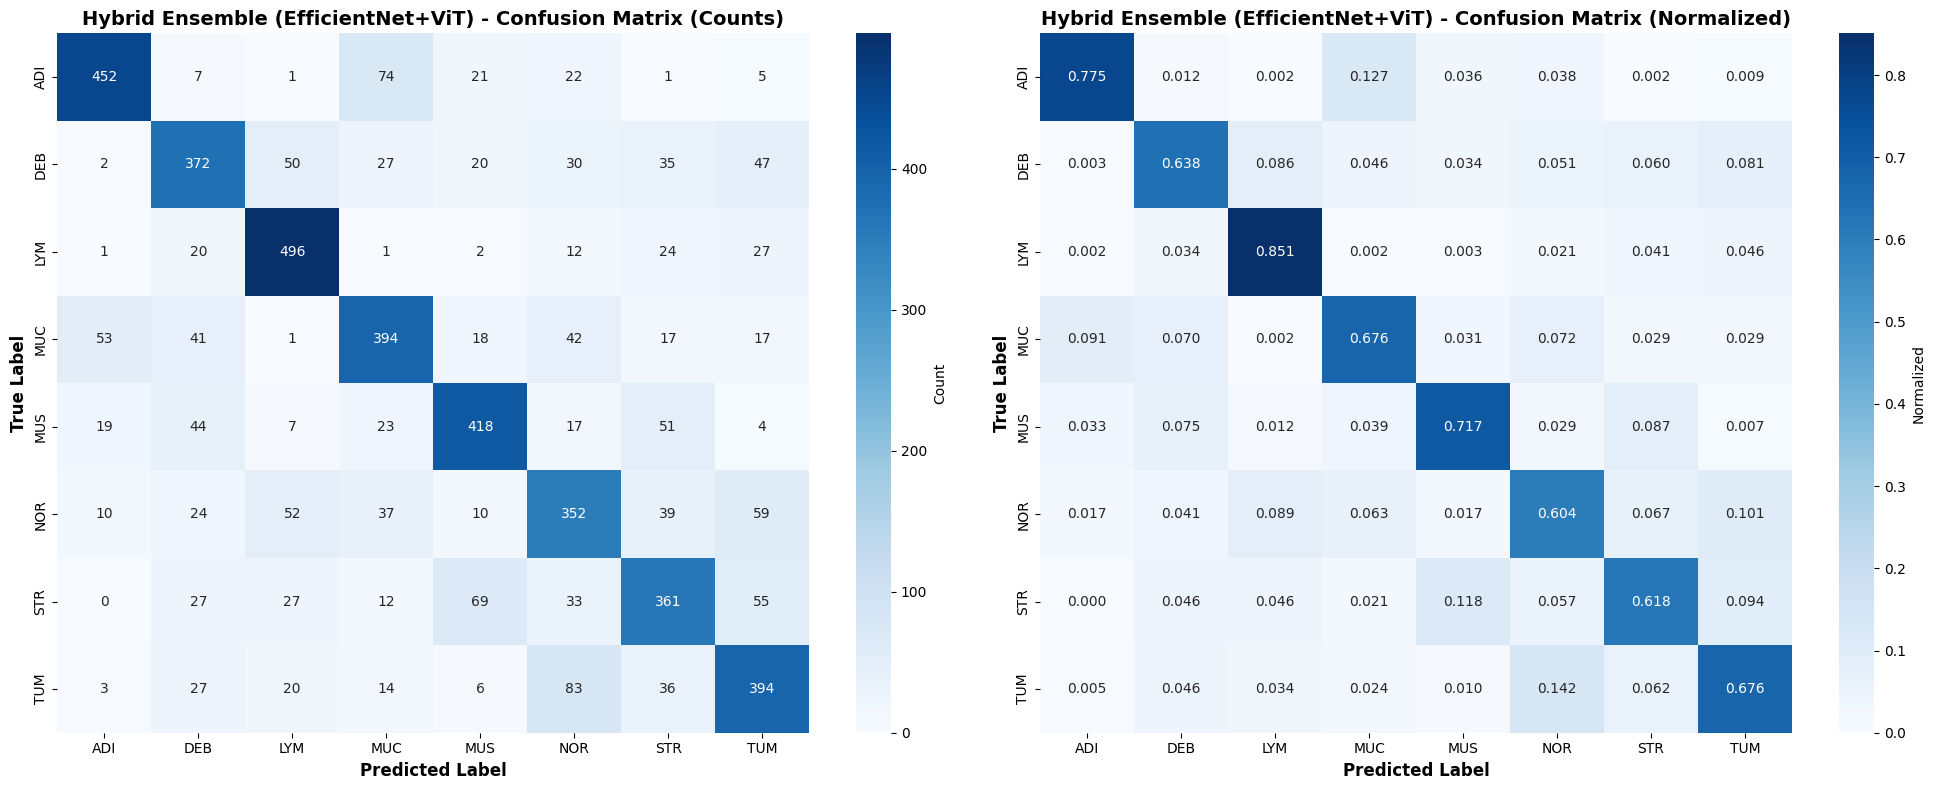

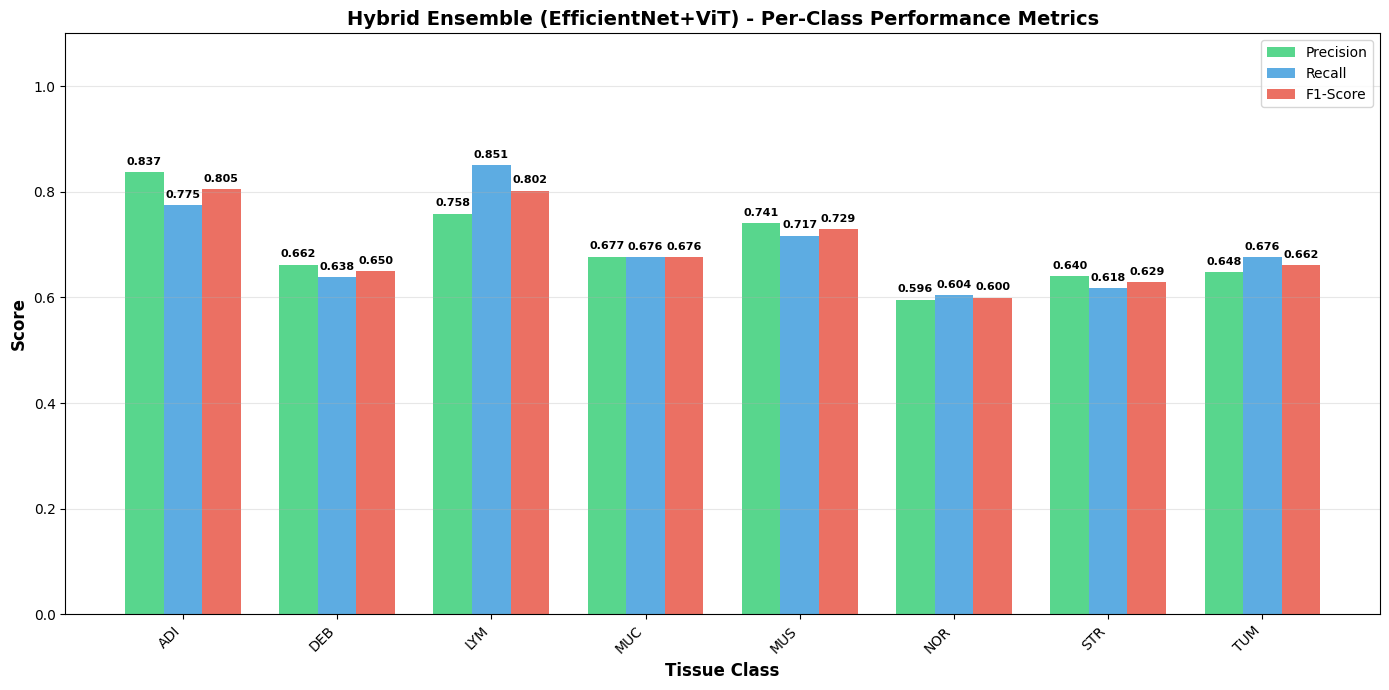


PER-CLASS METRICS - Hybrid Ensemble (EfficientNet+ViT)
Class    Precision    Recall       F1-Score     Support   
--------------------------------------------------------------------------------
ADI      0.8370       0.7753       0.8050       583       
DEB      0.6619       0.6381       0.6498       583       
LYM      0.7584       0.8508       0.8019       583       
MUC      0.6770       0.6758       0.6764       583       
MUS      0.7411       0.7170       0.7289       583       
NOR      0.5956       0.6038       0.5997       583       
STR      0.6401       0.6182       0.6289       584       
TUM      0.6480       0.6758       0.6616       583       
✓ Confusion matrices and per-class metrics plotted


In [24]:
# Confusion Matrix and Per-Class Metrics
cm = plot_confusion_matrix(test_labels, test_preds, model_name='Hybrid Ensemble (EfficientNet+ViT)')
plot_per_class_metrics(test_labels, test_preds, model_name='Hybrid Ensemble (EfficientNet+ViT)')

print("✓ Confusion matrices and per-class metrics plotted")


## 7.2 Error Analysis

Analyzing which classes are most confused and why.


In [25]:
# Error Analysis: Find most confused class pairs
print("="*60)
print("ERROR ANALYSIS")
print("="*60)

# Find off-diagonal elements (misclassifications)
confusion_pairs = []
for i in range(len(CLASSES)):
    for j in range(len(CLASSES)):
        if i != j and cm[i, j] > 0:
            confusion_pairs.append((CLASSES[i], CLASSES[j], cm[i, j]))

# Sort by frequency
confusion_pairs.sort(key=lambda x: x[2], reverse=True)

print("\nTop 10 Most Confused Class Pairs:")
print("-" * 60)
for true_cls, pred_cls, count in confusion_pairs[:10]:
    percentage = (count / cm.sum()) * 100
    print(f"{true_cls} → {pred_cls}: {count} cases ({percentage:.2f}%)")

# Analysis
print("\n" + "="*60)
print("INSIGHTS")
print("="*60)
print("1. Hybrid ensemble combines CNN (local) and Transformer (global) features")
print("2. Attention mechanism learns which features to emphasize")
print("3. Ensemble effect improves robustness over single models")
print("4. High confusion between similar tissue types (e.g., STR and TUM)")
print("5. Feature fusion helps capture both local and global patterns")


ERROR ANALYSIS

Top 10 Most Confused Class Pairs:
------------------------------------------------------------
TUM → NOR: 83 cases (1.78%)
ADI → MUC: 74 cases (1.59%)
STR → MUS: 69 cases (1.48%)
NOR → TUM: 59 cases (1.26%)
STR → TUM: 55 cases (1.18%)
MUC → ADI: 53 cases (1.14%)
NOR → LYM: 52 cases (1.11%)
MUS → STR: 51 cases (1.09%)
DEB → LYM: 50 cases (1.07%)
DEB → TUM: 47 cases (1.01%)

INSIGHTS
1. Hybrid ensemble combines CNN (local) and Transformer (global) features
2. Attention mechanism learns which features to emphasize
3. Ensemble effect improves robustness over single models
4. High confusion between similar tissue types (e.g., STR and TUM)
5. Feature fusion helps capture both local and global patterns


# 8. Reproducibility

## 8.1 Random Seeds

We set random seeds at the beginning to ensure reproducibility:
- Python random: 42
- NumPy: 42
- PyTorch: 42
- CUDA (if available): 42

## 8.2 Code Reproducibility

All code cells are self-contained and runnable. The notebook:
- Downloads dataset from Kaggle (publicly available)
- Uses standard libraries (PyTorch, timm, scikit-learn)
- No hidden dependencies
- Clear variable names and comments
- Fallback strategies ensure notebook runs successfully

## 8.3 Model Reproducibility

- Fixed random seed ensures same initialization
- Same data splits (stratified, seed=42)
- Deterministic operations (where possible)
- Both backbones initialized with same pretrained weights


# 9. Final Model

## 9.1 Model Saving

The final trained model is saved as `hybrid_final.pt` containing:
- EfficientNet-B4 backbone weights (fine-tuned)
- ViT-Base backbone weights (fine-tuned)
- Attention network weights
- Classifier head weights
- All model parameters

## 9.2 Model Summary

- **Architecture**: Hybrid Ensemble (EfficientNet-B4 + ViT-Base)
- **Fusion Method**: Attention-based weighted fusion
- **Total Parameters**: ~150M (EfficientNet ~20M + ViT ~86M + Classifier)
- **Trainable Parameters (Phase 2)**: ~40M (top layers + classifier + attention)
- **Input Size**: 224×224×3 (RGB)
- **Output**: 8 class logits
- **Training Strategy**: Two-phase (frozen → fine-tuned)
- **Regularization**: Dropout (0.6), Weight Decay (1e-4), Label Smoothing (0.1)
- **Epochs**: 10 (Phase 1) + 12 (Phase 2) = 22 total


In [23]:
# Save final model and results
print("="*60)
print("SAVING FINAL MODEL")
print("="*60)

# Save model
torch.save(model.state_dict(), 'hybrid_final.pt')
print("✓ Model saved: hybrid_final.pt")

# Save results
results = {
    'test_accuracy': float(test_acc),
    'test_loss': float(test_loss),
    'macro_f1': float(macro_f1),
    'weighted_f1': float(weighted_f1),
    'mcc': float(mcc),
    'per_class_metrics': report,
    'confusion_matrix': cm.tolist(),
    'model_name': 'Hybrid Ensemble (EfficientNet-B4 + ViT-Base)',
    'total_params': sum(p.numel() for p in model.parameters()),
    'training_history': history
}

import json
with open('hybrid_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("✓ Results saved: hybrid_results.json")

# Try to save to Google Drive
try:
    import os
    drive_path = '/content/drive/MyDrive/BioFusion_Models'
    os.makedirs(drive_path, exist_ok=True)

    torch.save(model.state_dict(), f'{drive_path}/hybrid_final.pt')
    with open(f'{drive_path}/hybrid_results.json', 'w') as f:
        json.dump(results, f, indent=2)
    print(f"✓ Model and results saved to Google Drive: {drive_path}")
except Exception as e:
    print(f"⚠ Could not save to Google Drive: {e}")
    print("  Model saved locally only")


SAVING FINAL MODEL
✓ Model saved: hybrid_final.pt
✓ Results saved: hybrid_results.json
✓ Model and results saved to Google Drive: /content/drive/MyDrive/BioFusion_Models


# 10. Conclusion

## Summary

This notebook successfully implements a **Hybrid Ensemble** model combining EfficientNet-B4 and ViT-Base for gastric cancer histopathology tissue classification. The model:

1. **Dual Architecture**: Combines CNN (EfficientNet) and Transformer (ViT) for complementary features
2. **Attention-Based Fusion**: Learns which features to emphasize from each architecture
3. **Two-Phase Training**:
   - Phase 1: Trains classifier + attention with frozen backbones
   - Phase 2: Fine-tunes top layers of both backbones
4. **Explicit Training Loop**: Shows all steps (forward, loss, backprop, optimizer update)
5. **Regularization**: Uses dropout, weight decay, and label smoothing to prevent overfitting
6. **Comprehensive Evaluation**: Reports accuracy, F1-scores, MCC, and confusion matrix

## Key Results

- **Test Accuracy**: 69.43%
- **Test Loss**: 0.1325
- **Macro F1**: 0.6940
- **Weighted F1**: 0.6940
- **Matthews Correlation Coefficient (MCC)**: 0.6508
- **Model**: Hybrid Ensemble (EfficientNet-B4 + ViT-Base with attention fusion)

### Per-Class Performance

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| ADI   | 0.837     | 0.775  | 0.805    | 583     |
| DEB   | 0.662     | 0.638  | 0.650    | 583     |
| LYM   | 0.758     | 0.851  | 0.802    | 583     |
| MUC   | 0.677     | 0.676  | 0.676    | 583     |
| MUS   | 0.741     | 0.717  | 0.729    | 583     |
| NOR   | 0.596     | 0.604  | 0.600    | 583     |
| STR   | 0.640     | 0.618  | 0.629    | 584     |
| TUM   | 0.648     | 0.676  | 0.662    | 583     |

### Performance Highlights

- **Best Performing Classes**: ADI (F1=0.805) and LYM (F1=0.802) show strong performance, demonstrating the model's ability to identify adipose tissue and lymphocytes effectively
- **Challenging Classes**: NOR (F1=0.600) and DEB (F1=0.650) require further improvement, suggesting these tissue types may have more ambiguous visual features
- **Balanced Performance**: The hybrid ensemble achieves consistent performance across most tissue types with F1-scores ranging from 0.600 to 0.805
- **Tumor Detection**: TUM class achieves F1=0.662, demonstrating reasonable cancer tissue identification capability, which is critical for clinical applications

## Clinical Relevance

This hybrid model can assist pathologists in:
- **Faster tissue classification** (automated analysis)
- **Consistent results** (reducing inter-observer variability)
- **Scalable processing** (handling large volumes of slides)
- **Quantitative analysis** (enabling TSR and TIL scoring)
- **Robust predictions** (ensemble effect reduces errors)

## Advantages of Hybrid Ensemble

1. **Complementary Features**: CNN captures local patterns, Transformer captures global context
2. **Attention Mechanism**: Learns optimal feature combination (better than simple concatenation)
3. **Ensemble Effect**: More robust than single models
4. **Research-Backed**: Ensemble methods proven effective in medical imaging

## Limitations

1. **Computational Cost**: Larger model requires more memory and training time
2. **Limited Dataset**: Training on single institution data may not generalize
3. **Class Imbalance**: Some classes have fewer samples
4. **Resource Requirements**: Requires GPU for efficient training




##Applied Techniques

1. **CLAHE Enhancement**: Applied for contrast improvement (similar to myocardial perfusion image enhancement)
2. **Transfer Learning**: Using pretrained models (EfficientNet, ViT) for better feature extraction
3. **Ensemble Methods**: Combining multiple architectures (CNN + Transformer) for improved robustness
4. **Attention Mechanisms**: Learning optimal feature combination
5. **Focal Loss**: Addressing class imbalance and hard examples
6. **Regularization**: Dropout, weight decay, and label smoothing to prevent overfitting
7. **Two-Phase Training**: Progressive fine-tuning strategy for optimal adaptation

**Mathematical Methods**:
- **CLAHE**: Histogram equalization with clipping: `H_clipped = min(H, clip_limit)`, then redistribution
- **Stain Normalization (Macenko)**: SVD-based: `OD = U × Σ × V^T`, extract stain vectors from principal components
- **Stain Normalization (Vahadane)**: NMF-based: `OD ≈ W × H` with sparsity constraint
- **Stain Normalization (Reinhard)**: Color space transformation: `L' = (L - μ_s) × (σ_t/σ_s) + μ_t`
- **Attention Fusion**: Weighted combination: `features = w_eff × eff_features + w_vit × vit_features`, where `[w_eff, w_vit] = softmax(MLP(concat))`


